## Task:
Bulunan dosyadaki talimat ve girişi birleştirerek soruları, çıktıyı ise sorunun cevabı olarak kullanınız.

Bir soruya en benzeyen 5 cevabı bulup gerçek cevaba göre top1 ve top5 başarılarını hesaplamak. rasgele 1000 soru üzerinden.
Bir cevaba en benzeyen 5 soruyu bulup gerçek soruya göre top1 ve top5 başarılarını hesaplamak. rasgele 1000 cevap üzerinden.

2 metin arasındaki benzerlik ölçümü olarak cosmos’daki BERT ve GPT modelleri (https://huggingface.co/ytu-ce-cosmos) ile temsilleri arasındaki açı kullanılacaktır. top 1 ve top 5 başarıları üzerinde BERT ve GPT’nin ve model büyüklüklerinin (en az 2’şer) etkileri karşılaştırılacaktır.

Soru ve cevabı, bu temsiller üzerine tsne uygulanarak 2 boyutta türlerine (soru/cevap) göre renklendirilerek görselleştirilecektir.

## Installing requirments libraries and dataset

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install -q --upgrade keras
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade tensorflow
!pip install -q --upgrade plotly_express
!pip install -q --upgrade datasets
!pip install -q --upgrade tensorflow-datasets
clear_output()

In [ ]:
!git lfs install

Git LFS initialized.


In [ ]:
!git clone https://huggingface.co/datasets/merve/turkish_instructions

fatal: destination path 'turkish_instructions' already exists and is not an empty directory.


## Importing

In [ ]:
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## First Look

In [ ]:
!ls /content/turkish_instructions/

instructions.csv  README.md


In [ ]:
!file /content/turkish_instructions/instructions.csv

/content/turkish_instructions/instructions.csv: CSV text


In [ ]:
!ls -l /content/turkish_instructions/instructions.csv

-rw-r--r-- 1 root root 21158634 Mar 24 11:35 /content/turkish_instructions/instructions.csv


In [ ]:
train_ds = pd.read_csv('/content/turkish_instructions/instructions.csv', encoding='utf-8')

In [ ]:
train_ds

,Unnamed: 0,talimat,giriş,çıktı
0,0,Aşağıdaki bağlamda orijinal bir şey söyleyin:...,NaN,Ekibe katkıda bulunmaya başlamak ve bu alanda...
1,1,Aşağıdaki makale için bir başlık önerin: Bu m...,NaN,"""Dijital İletişimin Gücü: İnternet İş Ortamın..."
2,2,Şu konuyla ilgili 5 anahtar kelimeden oluşan ...,NaN,1. Karbon emisyonları 2. Yenilenebilir enerji...
3,3,Bu cümleyi pasiften aktife değiştirin: Yeni p...,NaN,Belediye başkanı yeni politikayı açıkladı.
4,4,Aşağıdaki fenomeni tanımlayan üç bilimsel teri...,NaN,"Yerçekimi kuvveti, Newton'un evrensel çekim y..."
...,...,...,...,...
51558,51558,Finansal okuryazarlık konusunda eğitim veren ...,NaN,"Bu mobil uygulama, kullanıcılara finansal okur..."
51559,51559,Yavaş bir bilgisayarı düzeltmek için bir yönt...,NaN,Yavaş bir bilgisayar inanılmaz derecede sinir ...
51560,51560,Bir görevin başarısını değerlendirmek için bi...,Buluta geçiş.,"Buluta başarılı bir geçiş, buluta taşınan uygu..."
51561,51561,"Bu cümleyi yeniden yazın: ""Hedefe ulaşmanın en...",NaN,"Uçağa binmek, varış noktasına ulaşmanın en hı..."


In [ ]:
train_ds.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
train_ds.columns

Index(['talimat', ' giriş', ' çıktı'], dtype='object')

In [ ]:
train_ds.columns = ['instructions', 'input', 'answers']

In [ ]:
train_ds

,instructions,input,answers
0,Aşağıdaki bağlamda orijinal bir şey söyleyin:...,NaN,Ekibe katkıda bulunmaya başlamak ve bu alanda...
1,Aşağıdaki makale için bir başlık önerin: Bu m...,NaN,"""Dijital İletişimin Gücü: İnternet İş Ortamın..."
2,Şu konuyla ilgili 5 anahtar kelimeden oluşan ...,NaN,1. Karbon emisyonları 2. Yenilenebilir enerji...
3,Bu cümleyi pasiften aktife değiştirin: Yeni p...,NaN,Belediye başkanı yeni politikayı açıkladı.
4,Aşağıdaki fenomeni tanımlayan üç bilimsel teri...,NaN,"Yerçekimi kuvveti, Newton'un evrensel çekim y..."
...,...,...,...
51558,Finansal okuryazarlık konusunda eğitim veren ...,NaN,"Bu mobil uygulama, kullanıcılara finansal okur..."
51559,Yavaş bir bilgisayarı düzeltmek için bir yönt...,NaN,Yavaş bir bilgisayar inanılmaz derecede sinir ...
51560,Bir görevin başarısını değerlendirmek için bi...,Buluta geçiş.,"Buluta başarılı bir geçiş, buluta taşınan uygu..."
51561,"Bu cümleyi yeniden yazın: ""Hedefe ulaşmanın en...",NaN,"Uçağa binmek, varış noktasına ulaşmanın en hı..."


**Checking data compatibility if there any missing, NaN, duplicated data contains**

In [ ]:
def check_df(data):
  null_count = data.isna().sum()
  null_percentage = data.isna().sum() / len(data)
  null_percentage = null_percentage.apply(lambda x: f"{x:.1%}")
  print("Duplicated Data: ", data.duplicated().sum())
  result = pd.concat([null_count, null_percentage], axis=1)
  result.columns = ['Null Data', 'Null Data Percentage']
  return result
check_df(train_ds)

Duplicated Data:  0


,Null Data,Null Data Percentage
instructions,0,0.0%
input,32475,63.0%
answers,0,0.0%


In [ ]:
temp = train_ds["instructions"].fillna("") + train_ds["input"].fillna("") # Birlestirme

train_ds.drop(labels=['instructions', 'input'], axis=1, inplace=True)
train_ds['questions'] = temp

In [ ]:
train_ds = train_ds[['questions', 'answers']]

## Preprocessing

In [ ]:
import re # regular expression
def clean_data(text):
    text = tf.strings.lower(text).numpy().decode('utf-8') # Convert to lowercase
    text = re.sub('\[.*?\]', '', text) # Remove bracketed text
    text = re.sub('\n', '', text) # Remove new lines text
    return text

train_ds['questions'] = train_ds['questions'].apply(clean_data)
train_ds['answers'] = train_ds['answers'].apply(clean_data)

## Similarity with base-bert-uncased

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
model_name = 'ytu-ce-cosmos/turkish-base-bert-uncased'

In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
model_bert     = AutoModel.from_pretrained(model_name)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity between sequences.

similarity_scores_bert = []

sampled_data = train_ds.sample(1000)
# Computing every sentence
for index, row in sampled_data.iterrows():
    question = row['questions']
    answer = row['answers']

    # Convert all sentences to vectors
    question_tokens = tokenizer_bert(question, return_tensors='pt', padding=True, truncation=True)
    answer_tokens = tokenizer_bert(answer, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        question_output = model_bert(**question_tokens)
        answer_output = model_bert(**answer_tokens)

    question_embedding = question_output.last_hidden_state.mean(dim=1)
    answer_embedding = answer_output.last_hidden_state.mean(dim=1)

    # Cosine similarity computing
    similarity = cosine_similarity(question_embedding, answer_embedding)
    similarity_scores_bert.append(similarity[0][0])

In [ ]:
# Adding scores to dataframe
sampled_data['similarity_score_bert'] = similarity_scores_bert

In [ ]:
# Dropping unuseful labels from data
sampled_data.reset_index(inplace=True)

In [ ]:
sampled_data.drop(['index'], axis=1, inplace=True)

In [ ]:
sampled_data.iloc[sampled_data['similarity_score_bert'].idxmax()]

questions                 Çevrimiçi kişisel finans hizmetleriyle ilgili...
answers                  Çevrimiçi kişisel finans hizmetleri, kullanıcı...
similarity_score_bert                                             0.971689
Name: 704, dtype: object

## Similarity with turkish-gpt2

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
model_name = 'ytu-ce-cosmos/turkish-gpt2'

In [ ]:
tokenizer_gpt2 = AutoTokenizer.from_pretrained(model_name)
model_gpt2     = AutoModel.from_pretrained(model_name)

In [ ]:
tokenizer_gpt2.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores_gpt = []

sampled_data = train_ds.sample(1000)

# Computing every sentence
for index, row in sampled_data.iterrows():
    question = row['questions']
    answer = row['answers']

    # Tokenize all sentences
    question_tokens = tokenizer_gpt2(question, return_tensors='pt', padding=True, truncation=True)
    answer_tokens = tokenizer_gpt2(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        question_output = model_gpt2(**question_tokens)
        answer_output = model_gpt2(**answer_tokens)
    question_embedding = question_output.last_hidden_state.mean(dim=1)
    answer_embedding = answer_output.last_hidden_state.mean(dim=1)

    # Cosine similarity computing
    similarity = cosine_similarity(question_embedding, answer_embedding)
    similarity_scores_gpt.append(similarity[0][0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Adding scores to dataframe
sampled_data['similarity_score_gpt'] = similarity_scores_gpt

In [ ]:
sampled_data.reset_index(inplace=True)

In [ ]:
sampled_data.drop(['index'], axis=1, inplace=True)

In [ ]:
sampled_data.iloc[sampled_data['similarity_score_gpt'].idxmax()]

questions                dünyanın en kalabalık 8 ülkesini nüfuslarıyla...
answers                  Çin - 1,4 milyar hindistan - 1,3 milyar abd -...
similarity_score_gpt                                             0.963044
Name: 855, dtype: object

In [ ]:
sampled_data

,questions,answers,similarity_score_gpt
0,doğal dil işleme (nlp) görevleri için kullanı...,Çok katmanlı kümeleme kavramına dayalı yeni bi...,0.677029
1,"aşağıdaki hayvanları sınıflandırın: aslan, ge...",aslan - memeli geyik - memeli baykuş - kuş,0.793366
2,20'yi 5'e bölün.,20 bölü 5'in sonucu 4'tür.,0.855547
3,İki cümle arasında uygun geçişleri sağlamak i...,"dave fikrini hızla değiştirdi, bu yüzden sine...",0.738103
4,Üç yaşındaki bir erkek çocuk için satın alına...,Üç yaşındaki bir erkek çocuk için satın alına...,0.774257
...,...,...,...
995,verilen paragraftaki karakterleri ve rollerin...,verilen paragraftaki karakterler şunlardır: - ...,0.862880
996,bir brokoli çorbası için beş malzemeden oluşa...,brokoli çorbası için malzemeler: 1 baş brokol...,0.700676
997,"stockid, date ve price sütunlarına sahip bir ...",olası bir çözüm şöyle olabilir: ``` select sto...,0.777150
998,belirli bir cümleyi iki cümleye ayırın. ufukt...,sıcak bir gündü. ufukta bir fırtına vardı.,0.821659


In [ ]:
sampled_data['similarity_score_gpt'] = similarity_scores_gpt
sampled_data['similarity_score_bert'] = similarity_scores_bert
sampled_data

,questions,answers,similarity_score_gpt,similarity_score_bert
0,doğal dil işleme (nlp) görevleri için kullanı...,Çok katmanlı kümeleme kavramına dayalı yeni bi...,0.677029,0.853324
1,"aşağıdaki hayvanları sınıflandırın: aslan, ge...",aslan - memeli geyik - memeli baykuş - kuş,0.793366,0.921081
2,20'yi 5'e bölün.,20 bölü 5'in sonucu 4'tür.,0.855547,0.603027
3,İki cümle arasında uygun geçişleri sağlamak i...,"dave fikrini hızla değiştirdi, bu yüzden sine...",0.738103,0.759430
4,Üç yaşındaki bir erkek çocuk için satın alına...,Üç yaşındaki bir erkek çocuk için satın alına...,0.774257,0.883426
...,...,...,...,...
995,verilen paragraftaki karakterleri ve rollerin...,verilen paragraftaki karakterler şunlardır: - ...,0.862880,0.684582
996,bir brokoli çorbası için beş malzemeden oluşa...,brokoli çorbası için malzemeler: 1 baş brokol...,0.700676,0.822054
997,"stockid, date ve price sütunlarına sahip bir ...",olası bir çözüm şöyle olabilir: ``` select sto...,0.777150,0.740891
998,belirli bir cümleyi iki cümleye ayırın. ufukt...,sıcak bir gündü. ufukta bir fırtına vardı.,0.821659,0.791300


## Computing top1 and top5 with turkish-gpt2

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

question_top1_accuracy_with_gpt = 0
question_top5_accuracy_with_gpt = 0

answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

question_cosine_similarity_scores = []
answer_cosine_similarity_scores = []


for index, row in sampled_data.iterrows():
    """
    Args:
        'sampled_data_gpt': Which is the we took from data only 1000 sample.
    """
    question = row['questions']
    answer = row['answers']


    # Processing for question row
    question_tokens = tokenizer_gpt2(question, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        question_output = model_gpt2(**question_tokens)
    question_embedding = question_output.last_hidden_state.mean(dim=1)

    # Processing for answer row
    answer_tokens = tokenizer_gpt2(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model_gpt2(**answer_tokens)
    answer_embedding = answer_output.last_hidden_state.mean(dim=1)

    # Computing question and answer similarity
    question_similarity = cosine_similarity(question_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, question_embedding)

    # Appending similarity scores to list
    question_cosine_similarity_scores.append(question_similarity[0][0])

    # Finding closest similarity of indices
    question_closest_indices = np.array(question_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in question_closest_indices:
        question_top5_accuracy_with_gpt += 1
        if question_closest_indices[0] == index:
            question_top1_accuracy_with_gpt += 1

    # Appending similarity scores to list
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Finding closest similarity of indices
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

In [ ]:
answer_closest_indices

array([855, 987, 552, 342, 564])

In [ ]:
question_closest_indices

array([855, 987, 552, 342, 564])

In [ ]:
# Calculating success rate
question_top1_accuracy_with_gpt /= len(sampled_data)
question_top5_accuracy_with_gpt /= len(sampled_data)
answer_top1_accuracy_with_gpt /= len(sampled_data)
answer_top5_accuracy_with_gpt /= len(sampled_data)

print("Soru için Top 1 accuracy:", question_top1_accuracy_with_gpt)
print("Soru için Top 5 accuracy:", question_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)

Soru için Top 1 accuracy: 0.01
Soru için Top 5 accuracy: 0.026
Cevap için Top 1 accuracy: 0.01
Cevap için Top 5 accuracy: 0.026


## Computing top1 and top5 with bert-base

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

question_top1_accuracy_with_bert = 0
question_top5_accuracy_with_bert = 0

answer_top1_accuracy_with_bert = 0
answer_top5_accuracy_with_bert = 0

question_cosine_similarity_scores = []
answer_cosine_similarity_scores = []


for index, row in sampled_data.iterrows():
    """
    Args:
        'sampled_data_gpt': Which is the we took from data only 1000 sample.
    """
    question = row['questions']
    answer = row['answers']


    # Processing for question row
    question_tokens = tokenizer_bert(question, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        question_output = model_bert(**question_tokens)
    question_embedding = question_output.last_hidden_state.mean(dim=1)

    # Processing for answer row
    answer_tokens = tokenizer_bert(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model_bert(**answer_tokens)
    answer_embedding = answer_output.last_hidden_state.mean(dim=1)

    # Computing question and answer similarity
    question_similarity = cosine_similarity(question_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, question_embedding)

    # Appending similarity scores to list
    question_cosine_similarity_scores.append(question_similarity[0][0])

    # Finding closest similarity of indices
    question_closest_indices = np.array(question_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in question_closest_indices:
        question_top5_accuracy_with_bert += 1
        if question_closest_indices[0] == index:
            question_top1_accuracy_with_bert += 1

    # Appending similarity scores to list
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Finding closest similarity of indices
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_bert += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_bert += 1

In [ ]:
answer_closest_indices

array([552, 987, 933, 591, 213])

In [ ]:
question_closest_indices

array([552, 987, 933, 591, 213])

In [ ]:
# Calculating success rate
question_top1_accuracy_with_bert /= len(sampled_data)
question_top5_accuracy_with_bert /= len(sampled_data)
answer_top1_accuracy_with_bert /= len(sampled_data)
answer_top5_accuracy_with_bert /= len(sampled_data)

print("Soru için Top 1 accuracy:", question_top1_accuracy_with_bert)
print("Soru için Top 5 accuracy:", question_top5_accuracy_with_bert)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_bert)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_bert)

Soru için Top 1 accuracy: 0.005
Soru için Top 5 accuracy: 0.027
Cevap için Top 1 accuracy: 0.005
Cevap için Top 5 accuracy: 0.027


## TSNE

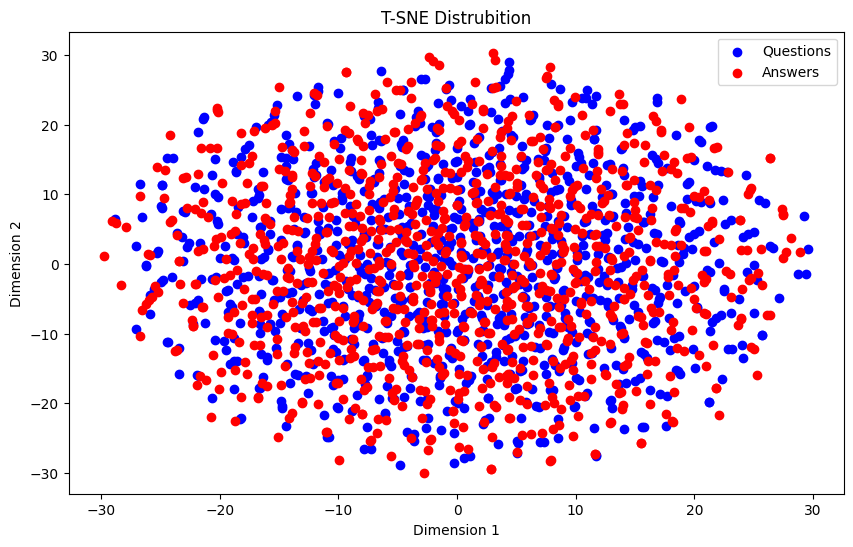

In [ ]:
from sklearn.manifold import TSNE

def get_embeddings(text_data):

    embeddings = np.random.rand(len(text_data), 300)
    return embeddings

questions_text = sampled_data['questions']
answers_text = sampled_data['answers']


questions_embeddings = get_embeddings(questions_text)
answers_embeddings = get_embeddings(answers_text)


tsne = TSNE(n_components=2, random_state=42)
questions_2d = tsne.fit_transform(questions_embeddings)
answers_2d = tsne.fit_transform(answers_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(questions_2d[:, 0], questions_2d[:, 1], color='blue', label='Questions')
plt.scatter(answers_2d[:, 0], answers_2d[:, 1], color='red', label='Answers')
plt.title('T-SNE Distrubition')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()
